# Bayesian regression from scratch

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2,multivariate_normal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [20]:
from itertools import combinations_with_replacement

def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new

In [23]:
class BayesianRegression(object):
    """ Parameters:
        n_draws: the number of draws from the posterior of the parameters.
        mu0: the mean values of the prior normal distribution of the parameters.
        omega0: the precision matrix (variance) of the prior normal distribution of the parameters.
        nu0: the degrees of freedom of the prior scaled invariance chi squared distribution.
        sigma_sq0: the scale parameter of the prior scaled inverse chi squared distribution
        *poly_degree: the polynomial degree that the features should be transformed to.
        cred_int: The credible interval (ETI in this implementation) 95 => 95% credible intervals 
            of the posterior of the parameters.
    
    """
    def __init__(self,n_draws,mu0,omega0,nu0,sigma_sq0,poly_degree=0,cred_int=95):
        self.w = None
        self.n_draws = n_draws
        self.poly_degree = poly_degree
        self.cred_int = cred_int
        
        # Prior parameters
        self.mu0 = mu0
        self.omega0 = omega0
        self.nu0 = nu0
        self.sigma_sq0 = sigma_sq0
    # Simulation based on the scaled inverse chi squared distribution.
    # The scaled inverse chi-squared distribution is the distribution for x = 1/s2,
    # where s2 is a sample mean of the squares of ν independent normal random variables that have 
    # mean 0 and inverse variance 1/σ2 = τ2
    def _draw_scaled_inv_chi_sq(self,n,df,scale):
        X = chi2.rvs(size = n, df = df)
        sigma_sq = df*scale/X
        return sigma_sq
    # Fitting function
    def fit(self,X,y):
        # if polynomial transformation is need to be applied on the covariates
        if self.poly_degree:
            X = polynomial_features(X,degree = self.poly_degree)
        
        n_samples,n_features = np.shape(X)
        # X times to transpose(X)
        X_X = X.T.dot(X)
        # Least square approximate of beta
        # inv(X*transpose(X))* transpose(X)*Y
        beta_hat = np.linalg.pinv(X_X).dot(X.T).dot(y)
        
        # The posterior parameters can be determined analytically using the conjugate property of Bayesian for the likelihood
        # Normal Posterior <= Normal prior*likelihood
        
        mu_n = np.linalg.pinv(X_X + self.omega0).dot(X_X.dot(beta_hat) + self.omega0.dot(self.mu0))
        omega_n = X_X + self.omega0
        
        # Scale inverse chi-squared posterior <= likelihood * scaled inverse chi-squared prior
        nu_n = self.nu0 + n_samples
        sigma_sq_n = (1.0/nu_n)*(self.nu0*self.sigma_sq0 + \
                                (y.T.dot(y)) + self.mu0.T.dot(self.omega0).dot(self.mu0) - mu_n.T.dot(omega_n.dot(mu_n)))
        
        # Simulate parameter values for n_draws
        beta_draws = np.empty((self.n_draws,n_features))
        for i in range(self.n_draws):
            sigma_sq = self._draw_scaled_inv_chi_sq(n=1,df = nu_n, scale = sigma_sq_n)
            beta = multivariate_normal.rvs(size = 1, mean = mu_n[:,0], cov = sigma_sq*np.linalg.pinv(omega_n))
            # save parameter draws
            beta_draws[i,:] = beta
            
        # select the mean of the simulated variables as the ones used to make predictions
        self.w = np.mean(beta_draws,axis = 0)
        
        # Lower and upper boundary of the credible intervals
        l_eti = 50 - self.cred_int/2
        u_eti = 50 + self.cred_int/2
        self.eti = np.array([[np.percentile(beta_draws[:,i],q = l_eti),np.percentile(beta_draws[:,i], q = u_eti)] for i in range(n_features)])
        
        
    def predict(self,X,eti = False):
        
        # If polynomial transformation
        if self.poly_degree:
            X = polynomial_features(X,degree = self.poly_degree)
        
        y_pred = X.dot(self.w)
        # if lower and upper boundaries for the 95% then equal tail interval should be returned
        
        if eti:
            lower_w = self.eti[:,0]
            upper_w = self.eti[:,1]
            y_lower_pred = X.dot(lower_w)
            y_upper_pred = X.dot(upper_w)
            return y_pred, y_lower_pred,y_upper_pred
        
        return y_pred
        
        

Mean Squared Error: 17.894691162498457


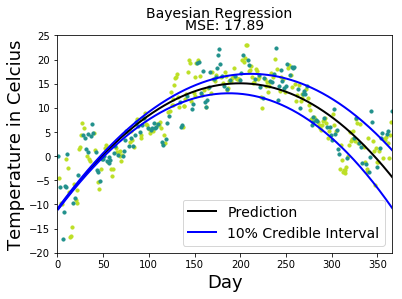

In [32]:
def main():

    # Load temperature data
    data = pd.read_csv('/Users/omidbazgir/Google Drive/Github_codes/TempLinkoping2016.txt', sep="\t")

    time = np.atleast_2d(data["time"].values).T
    temp = np.atleast_2d(data["temp"].values).T

    X = time # fraction of the year [0, 1]
    y = temp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    n_samples, n_features = np.shape(X)

    # Prior parameters
    # - Weights are assumed distr. according to a Normal distribution
    # - The variance of the weights are assumed distributed according to 
    #   a scaled inverse chi-squared distribution.
    # High prior uncertainty!
    # Normal
    mu0 = np.array([0] * n_features)
    omega0 = np.diag([.0001] * n_features)
    # Scaled inverse chi-squared
    nu0 = 1
    sigma_sq0 = 100

    # The credible interval
    cred_int = 10

    clf = BayesianRegression(n_draws=2000, 
        poly_degree=3, 
        mu0=mu0, 
        omega0=omega0, 
        nu0=nu0, 
        sigma_sq0=sigma_sq0,
        cred_int=cred_int)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    # Get prediction line
    y_pred_, y_lower_, y_upper_ = clf.predict(X=X, eti=True)

    # Print the mean squared error
    print ("Mean Squared Error:", mse)

    # Color map
    cmap = plt.get_cmap('viridis')

    # Plot the results
    m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
    p1 = plt.plot(366 * X, y_pred_, color="black", linewidth=2, label="Prediction")
    p2 = plt.plot(366 * X, y_lower_, color="blue", linewidth=2, label="{0}% Credible Interval".format(cred_int))
    p3 = plt.plot(366 * X, y_upper_, color="blue", linewidth=2)
    plt.axis((0, 366, -20, 25))
    plt.suptitle("Bayesian Regression", fontsize=14)
    plt.title("MSE: %.2f" % mse, fontsize=14)
    plt.xlabel('Day', fontsize=18)
    plt.ylabel('Temperature in Celcius', fontsize=18)
    plt.legend(loc='lower right', fontsize=18)
    # plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.legend(loc='lower right', fontsize=14)

    plt.show()

if __name__ == "__main__":
    main()